In [1]:
import time
import requests
import pandas as pd
import numpy as np

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape, mse
from utilsforecast.evaluation import evaluate

api_key = 'nixak-d84ihFiuZV4enObePImEW5m0SPKLGWs5wwBKwSWxeot1u60CHTWRRD4OboD5sMLJh7kN9iixkJTtlHMu'

nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = api_key
)x

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])


df.groupby('unique_id').head(2)

,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
8784,DOM-DOM,2023-10-01 04:00:00+00:00,10732.435
8785,DOM-DOM,2023-10-01 05:00:00+00:00,10314.211
17568,JC-JC,2023-10-01 04:00:00+00:00,1825.101
17569,JC-JC,2023-10-01 05:00:00+00:00,1729.590
26352,PN-PN,2023-10-01 04:00:00+00:00,1454.666
26353,PN-PN,2023-10-01 05:00:00+00:00,1416.688
35136,RTO-RTO,2023-10-01 04:00:00+00:00,69139.393
35137,RTO-RTO,2023-10-01 05:00:00+00:00,66207.416


In [2]:
from utilsforecast.plotting import plot_series
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [3]:
def generate_inputs(df, days=73):

    test_df = df.groupby('unique_id').tail(24 * days)
    train_df = df.groupby('unique_id').apply(lambda group: group.iloc[:-1 * (24 * days)]).reset_index(drop=True)


    #create list of 73 days true values for each unique_id
    Y_df = [
    test_df.groupby('unique_id', group_keys=False).apply(lambda group: group.iloc[i:i+24]).reset_index(drop=True)
    for i in range(0, 24 * days, 24)
    ]

    p = 1

    #create paired inputs
    inputs_df = [Y_df[i] for i in range(len(Y_df) - p)]

    inputs_df.insert(0, train_df.groupby('unique_id', group_keys=False).apply(lambda group: group.iloc[-24:]))


    return Y_df, inputs_df, train_df, test_df


In [ ]:
Y_df, inputs_df, train_df, test_df = generate_inputs(df)

In [ ]:
'''
import shutil 

filename = "checkpoints_p1days.zip"
extract_dir = "checkpoints"
archive_format = "zip"

shutil.unpack_archive(filename, extract_dir, archive_format)

In [5]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, LSTM

nf = NeuralForecast.load(path='./checkpoints/models/')

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [15]:
subset = train_df[train_df['unique_id'] == 'AP-AP']['y'].values
subset = subset.reshape(-1,24)


In [16]:
subset.shape

(293, 24)

In [38]:
    
    # get the uniaue_id of the current location
u_id = 'DOM-DOM'

# Get the indices of the worst predicted day
worst_day = int(dom_mae[dom_mae['unique_id'] == u_id].loc[0, 'n_day'] - 1)

worst_day

14

In [31]:
worst_day_function = np.array(test_df.loc[test_df['unique_id'] == u_id, 'y'].iloc[(worst_day - 1) * 24: worst_day * 24 ].values)

# Compute distances for all worst_day_function at once
distances = np.linalg.norm(subset - worst_day_function, axis=1) 


distances

array([10956.68185077,  8193.18925017,  7565.45762988,  7586.60195537,
        8467.35135507,  9261.95347804, 12479.77524129, 12146.85810828,
        9700.37977452, 10062.84110383,  9977.3841495 , 10088.07942745,
       10797.36242718, 11203.7469026 , 11544.72636546,  9359.44049494,
        9226.63152426,  9370.07620405,  9429.21550166,  9927.62479804,
       11251.79488999, 11214.70639043,  9043.62271652,  9200.41862911,
        9740.06431237,  9917.26683107, 10101.93835622, 10969.87197856,
       11414.19391232,  8820.27122243,  7774.01185047,  5931.10027356,
        6944.99917207,  8358.42484806, 10043.73288967, 10915.91421333,
        8338.11840084,  9135.27340365,  9111.40286096,  8903.26414496,
        7702.02005414,  9117.84059664,  9014.94182744,  7220.12923569,
        7573.7209848 ,  7617.48211456,  8298.44559206,  8764.28696107,
        9982.53249707,  9069.11415923,  6432.5558896 ,  5035.78053672,
        6850.4123616 ,  9616.5795705 ,  8341.25261741,  7296.02758582,
      

In [33]:
# Get the indices of the 5 closest matches for each function
closest_indices = np.argsort(distances, axis=0)[:5]

closest_indices

array([290, 262, 263, 261, 264])

In [34]:
ap_mae = pd.read_csv('./mae_differences/AP_mae.csv')
dom_mae = pd.read_csv('./mae_differences/DOM_mae.csv')
jc_mae = pd.read_csv('./mae_differences/JC_mae.csv')
pn_mae = pd.read_csv('./mae_differences/PN_mae.csv')
rto_mae = pd.read_csv('./mae_differences/RTO_mae.csv')

In [35]:
locations = [ap_mae, dom_mae, jc_mae, pn_mae, rto_mae]

In [50]:
locations_closest = pd.DataFrame()

for location in locations:
    
    # get the uniaue_id of the current location
    u_id = location['unique_id'][0] 
    
    # Get the indices of the worst predicted day
    worst_day = int(location[location['unique_id'] == u_id].loc[0, 'n_day'] - 1)

    # Extract corresponding function from test_df
    worst_day_function = np.array(test_df.loc[test_df['unique_id'] == u_id, 'y'].iloc[(worst_day - 1) * 24: worst_day * 24].values)

    # Compute distances for all worst_day_function at once
    subset = train_df[train_df['unique_id'] == u_id]['y'].values.reshape(-1, 24) 
    distances = np.linalg.norm(subset - worst_day_function, axis=1)  # Efficient L2 norm calculation

    # Get the indices of the 5 closest matches for each function
    closest_indices = np.argsort(distances, axis=0)[:5]

    # Convert to a DataFrame if needed
    closest_indices_df = pd.DataFrame(closest_indices, columns=[u_id])

    locations_closest[u_id] = closest_indices_df + 1

In [51]:
locations_closest

,AP-AP,DOM-DOM,JC-JC,PN-PN,RTO-RTO
0,291,291,266,281,291
1,263,284,288,276,284
2,264,289,267,272,262
3,262,283,285,105,263
4,265,280,279,58,264


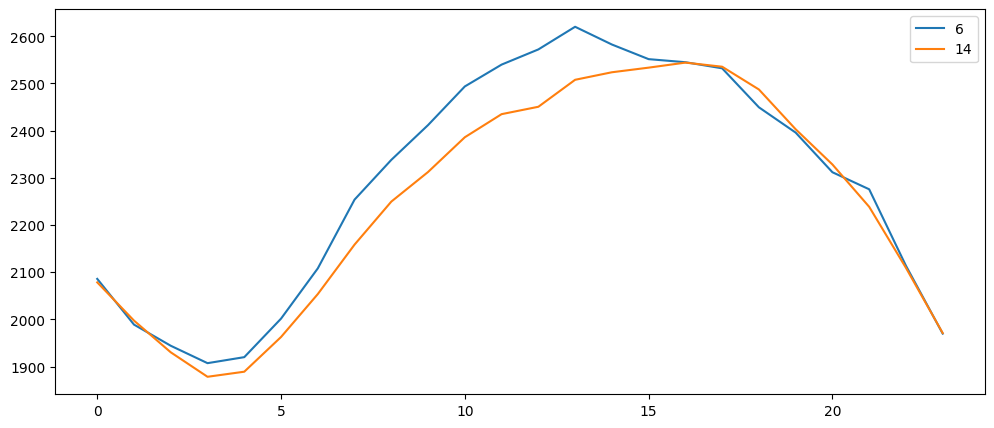

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))


plt.plot(train_df[train_df['unique_id'] == 'PN-PN'][290 * 24: 290 * 24 + 24]['y'].values, label='6')
plt.plot(test_df[test_df['unique_id'] == 'PN-PN'][13 * 24: 13 * 24 + 24]['y'].values, label='14')

plt.legend()
plt.show()